<a href="https://colab.research.google.com/github/jear2412/MetodosLineales/blob/master/LDAcancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#----- LDA

import numpy as np
import scipy
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme(style="darkgrid") 

In [2]:
# leer archivo wdbc.csv

# 569 x 32 (Ejemplo tomado de Izenman (2008) p.238)
# radius  = Radius of an individual nucleus
# texture = Variance of gray levels inside the boundary of the nucleus
# peri    = Distance around the perimeter of the nucleus
# area    = Area of the nucleus
# smooth  = Smoothness of the contour of a nucleus as measured by the
#           local variation of radial segments
# comp   = A measure of the compactness of a cell nucleus using the
#  formula (peri)2/area

#
# scav = Severity of concavities or indentations in a cell nucleus
# using asize measurement that emphasizes small indentations
#
# ncav = Number of concave points or indentations in a cell nucleus
# symt = Symmetry of a cell nucleus
# fracd = Fractal dimension (of the boundary) of a cell
  


dat = pd.read_csv('wdbc.csv')

In [3]:
dat

,Unnamed: 0,id,Class,radius.mv,texture.mv,peri.mv,area.mv,smooth.mv,comp.mv,scav.mv,ncav.mv,symt.mv,fracd.mv,radius.sd,texture.sd,peri.sd,area.sd,smooth.sd,comp.sd,scav.sd,ncav.sd,symt.sd,fracd.sd,radius.ev,texture.ev,peri.ev,area.ev,smooth.ev,comp.ev,scav.ev,ncav.ev,symt.ev,fracd.ev
0,1,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,2,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,3,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,4,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,5,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,565,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,566,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,567,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,568,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [9]:
# Class debe ser categorica

dat.Class = pd.Categorical(dat.Class)
dat['code'] = dat.Class.cat.codes

In [10]:
# # Transformacion logaritmica

aa = dat.iloc[:, 3:33]

index= aa>0

aa[index]=np.log(aa[index])
aa[-index]=np.log( 0.001)

datl=aa


In [11]:
datl

,radius.mv,texture.mv,peri.mv,area.mv,smooth.mv,comp.mv,scav.mv,ncav.mv,symt.mv,fracd.mv,radius.sd,texture.sd,peri.sd,area.sd,smooth.sd,comp.sd,scav.sd,ncav.sd,symt.sd,fracd.sd,radius.ev,texture.ev,peri.ev,area.ev,smooth.ev,comp.ev,scav.ev,ncav.ev,symt.ev,fracd.ev
0,2.889816,2.339881,4.810557,6.908755,-2.133687,-1.281574,-1.203640,-1.916643,-1.419231,-2.541985,0.090754,-0.099489,2.150482,5.033049,-5.051614,-3.015119,-2.923784,-4.143325,-3.505558,-5.084336,3.233961,2.852439,5.218191,7.610358,-1.818925,-0.407066,-0.339818,-1.326517,-0.776311,-2.129472
1,3.023834,2.877512,4.889597,7.189922,-2.468168,-2.542875,-2.442997,-2.656834,-1.708154,-2.870510,-0.609726,-0.309382,1.223187,4.305146,-5.254300,-4.336671,-3.984594,-4.312501,-4.276586,-5.645891,3.218476,3.153163,5.067646,7.578657,-2.089088,-1.678788,-1.420472,-1.682009,-1.290984,-2.418894
2,2.980111,3.056357,4.867534,7.092574,-2.210918,-1.833207,-1.622523,-2.056507,-1.575520,-2.813577,-0.293566,-0.239654,1.522790,4.543614,-5.091303,-3.217377,-3.261783,-3.883436,-3.794240,-5.388023,3.159975,3.239854,5.027165,7.443664,-1.935168,-0.856843,-0.797619,-1.414694,-1.018047,-2.435203
3,2.435366,3.014554,4.351310,5.956096,-1.948413,-1.259133,-1.421300,-2.251892,-1.348228,-2.328518,-0.701986,0.144966,1.236924,3.304319,-4.698383,-2.595883,-2.871570,-3.980837,-2.819596,-4.687683,2.702032,3.277145,4.593806,6.341593,-1.561601,-0.143524,-0.375567,-1.356736,-0.409774,-1.754464
4,3.010128,2.663053,4.906015,7.167809,-2.299590,-2.018911,-1.619488,-2.260484,-1.709811,-2.833103,-0.278128,-0.246796,1.693411,4.547965,-4.466278,-3.704602,-2.866811,-3.971242,-4.042132,-5.275578,3.115292,2.813611,5.025195,7.362011,-1.984859,-1.584745,-0.916291,-1.817077,-1.442230,-2.566811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,3.070840,3.108614,4.955827,7.299121,-2.198225,-2.155028,-1.410997,-1.974001,-1.756779,-2.878305,0.162119,0.227932,2.037708,5.067016,-4.575611,-3.543568,-2.956896,-3.707451,-4.497213,-5.463428,3.236716,3.273364,5.112590,7.614312,-1.958995,-1.554476,-0.889892,-1.506881,-1.579879,-2.642965
565,3.002211,3.341093,4.876723,7.139660,-2.324831,-2.269150,-1.937942,-2.323707,-1.741827,-2.894440,-0.267226,0.901380,1.649235,4.595524,-5.155257,-3.720164,-3.231455,-4.087568,-3.964369,-5.992265,3.165053,3.644144,5.043425,7.456455,-2.149006,-1.649219,-1.134758,-1.815233,-1.357901,-2.712510
566,2.809403,3.335058,4.684905,6.754721,-2.470412,-2.279846,-2.380439,-2.937086,-1.838851,-2.873869,-0.784386,0.072321,1.231101,3.882594,-5.132295,-3.288494,-3.051245,-4.162409,-4.329055,-5.548832,2.943386,3.529884,4.841822,7.024649,-2.172434,-1.173120,-1.077928,-1.953338,-1.505979,-2.548486
567,3.025291,3.378611,4.942356,7.142827,-2.138767,-1.283738,-1.045830,-1.883875,-1.428367,-2.656977,-0.320205,0.466874,1.753019,4.456902,-5.032574,-2.787418,-2.642684,-4.095946,-3.761880,-5.085628,3.248046,3.674273,5.218191,7.507141,-1.801810,-0.141448,-0.063259,-1.328025,-0.894774,-2.087474


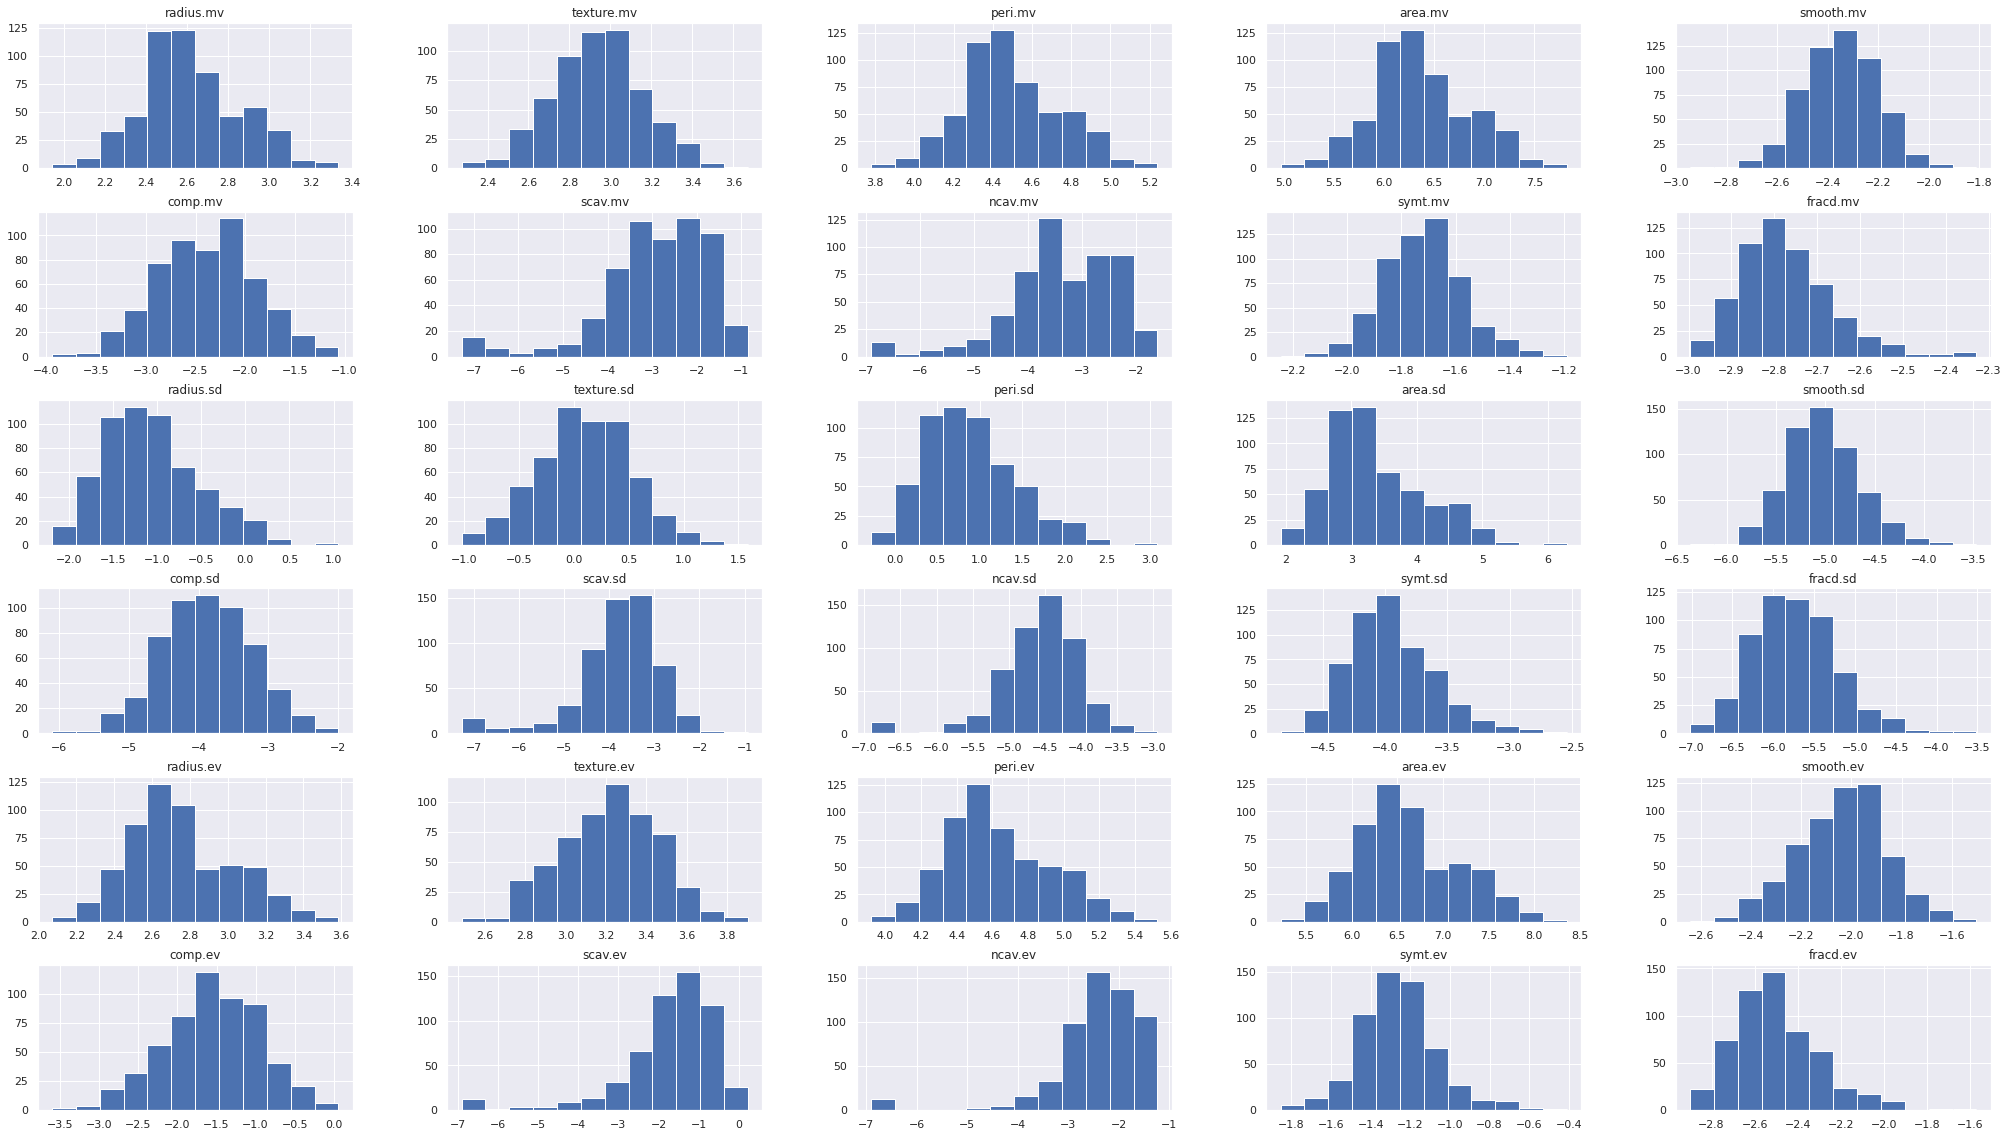

In [12]:
#histogramas
pd.DataFrame.hist(datl, bins=12, figsize=(35,20))
plt.show()


In [16]:
#-----------------------------------

#B benignos
datB= datl.loc[ dat['code']==0, : ]
nB= datB.shape[0]
medB= np.mean(datB)
SB   = pd.DataFrame.cov(datB)

#M Malignos
datM= datl.loc[ dat['code']==1, : ]
nM=datM.shape[0]
medM=np.mean(datM)
SM   = pd.DataFrame.cov(datM)



SS   = ( (nB-1)*SB + (nM-1)*SM ) / (nB+nM-2) # Estimador pooled de Sigma
n    = nB+nM
piB  = nB/n #estimadores de probabilidades a priori
piM  = nM/n

Sinv=np.linalg.inv(SS)

In [17]:
# b'x+b0> 0 es una v.a gaussiana real

#LDA

b0= np.log (piB/ piM)- 1/2 *np.transpose(medB)@np.linalg.inv(SS)@medB+1/2 *np.transpose(medM)@np.linalg.inv(SS)@medM
b= np.transpose(medB-medM)@Sinv


In [18]:
# Scores (Evaluacion de la funcion discriminante)

#Scores positivos son de B y negativos son de M

scoresB= b0+ datB@b #deben dar positivos, puntaje de ser benigno
scoresM= b0+ datM@b #deben dar negativos, puntaje de ser maligno

Text(0, 0.5, 'Conteos')

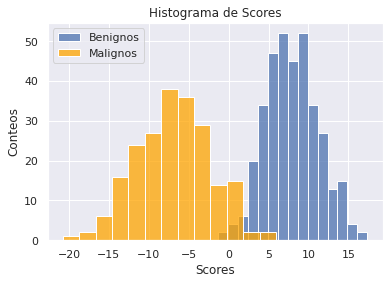

In [19]:
sns.histplot(scoresB, kde=False, label='Benignos')
sns.histplot(scoresM, kde=False, color='Orange',  label='Malignos')
plt.legend()
plt.title('Histograma de Scores')
plt.xlabel('Scores')
plt.ylabel('Conteos')

In [20]:
# Bondad del clasificador

#error del clasificador

print('Error: ', 100*(np.sum(scoresB<=0)+np.sum(scoresM>=0))/n)



Error:  3.3391915641476273


In [21]:
# Validacion cruzada : es una forma de evaluar nuestro modelo

#leave one out cross validation (loocv)
classifCV=np.zeros(n)

for i in range(n):
  x=datl.iloc[i,:]
  datmi=datl.drop( datl.index[i] ) #dat missing
  index= dat['code']==0
  index[i]=1
  datB=datmi.loc[ index, : ]
  nB= datB.shape[0]
  medB= np.mean(datB)
  SB   = pd.DataFrame.cov(datB)

  index= dat['code']==1
  index[i]=0
  datM= datmi.loc[ index, : ]
  nM= datM.shape[0]
  medM=np.mean(datM)
  SM   = pd.DataFrame.cov(datM)

  SS   = ( (nB-1)*SB + (nM-1)*SM ) / (nB+nM-2)
  
  Sinv=np.linalg.inv(SS)
  b0= np.log (piB/ piM)- 1/2 *np.transpose(medB)@np.linalg.inv(SS)@medB+1/2 *np.transpose(medM)@np.linalg.inv(SS)@medM
  b= np.transpose(medB-medM)@Sinv

  ssCV= b0+np.sum( x*b )

  if ssCV>0: 
    classifCV[i]=0
  else:
    classifCV[i]=1


In [23]:
#valores reales 

dat.Class.value_counts() 

B    357
M    212
Name: Class, dtype: int64

In [24]:
np.sum(classifCV== dat.code) #en cuantas es igual lo que clasificamos que lo que vimos?

545

In [25]:
print( 'error de validacion cruzada: ', 100*(1-np.sum(classifCV== dat.code)/n ) ) #error mas real

error de validacion cruzada:  4.217926186291743
